In [1]:
# Data
import yfinance as yf
import yahooquery 

# Maths
import numpy as np
import pandas as pd
from scipy.optimize import minimize, differential_evolution
from scipy import stats
from statsmodels.tsa.stattools import coint

# Visualization
from matplotlib import pyplot as plt
import seaborn as sns

# Data handling
import pandas_datareader as pdr
import pandas_market_calendars as mcal

# Utility
import datetime

In [2]:
def Get_top_10_ETF_symbols(ETF):
    holdings = yahooquery.Ticker(ETF).fund_holding_info[ETF]['holdings']
    return [holding['symbol'] for holding in holdings]
def Get_ETF_data(ETF):
    tickers = Get_top_10_ETF_symbols(ETF)
    df = yf.download(tickers, start=valid_start_day)['Open']
    df = df.dropna(axis=1, how='any')
    return df

In [3]:
# Date and Time
end_date = datetime.date.today()
start_date = end_date - datetime.timedelta(days=365)
nyse = mcal.get_calendar('NYSE')
valid_dates = nyse.valid_days(start_date=start_date, end_date =end_date)
valid_start_day = valid_dates[0].date()
valid_end_day = valid_dates[-1].date()

# List of ETF: https://en.wikipedia.org/wiki/List_of_American_exchange-traded_funds 

#SMH_top_10_tickers = Get_top_10_ETF_symbols('SMH') # VanEck Semiconductor ETF
#AMLP_top_10_tickers = Get_top_10_ETF_symbols('AMLP') # energy, ALPS Alerian MLP ETF
#VDE_top_10_tickers = Get_top_10_ETF_symbols('VDE') # Vanguard Energy
#XLF_top_10_tickers = Get_top_10_ETF_symbols('XLF') # Financial Select Sector SPDR
#VOO_top_10_tickers = Get_top_10_ETF_symbols('VOO') # Vanguard S&P 500 ETF

# Download data
df = Get_ETF_data('XOP')

[*********************100%%**********************]  10 of 10 completed


In [4]:
# Split data
def Log_return(df): # We use log return as the time series instead of the stock itself (got more nicer properties!)
    return np.log(df/df.shift(1)).dropna()
TT_split = 0.95 #you need constant update so Train-test split must be large to see good result

Train_df = df[:int(len(df)*TT_split)]
Train_df_return = Log_return(Train_df)

Test_df = df[int(len(df)*TT_split):]

In [5]:
def find_cointegrated_pairs(df):
    n = df.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = df.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = df[keys[i]]
            S2 = df[keys[j]]
            result = coint(S1, S2) # return: Test Statistic, P-value, Critical Values
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.01:
                pairs.append([keys[i], keys[j]])
    return score_matrix, pvalue_matrix, pairs

def calculate_spread_zscore(pair, df, window):
    stock1 = df[pair[0]]
    stock2 = df[pair[1]]
    spread = stock1 - stock2
    zscore = (spread - spread.rolling(window=window).mean()) / spread.rolling(window=window).std()
    return zscore

In [6]:
# Calculate rolling z
z_score_window = 20

# Find cointegrated pairs
score_matrix, pvalue_matrix, cointegrated_pairs = find_cointegrated_pairs(Train_df_return)

print(f"Found {len(cointegrated_pairs)} cointegrated pairs:")

Found 45 cointegrated pairs:


In [7]:
def backtest(df,TT_split,pairs,z_score_window,z_entry,z_exit,opt_mode=False):
    Train_len = int(len(df)*(TT_split))
    Test_position = pd.DataFrame().reindex_like(df[Train_len:])
    Test_position[:] = 0
    Transaction_cost = 3 #USD per transaction

    for i, pair in enumerate(pairs):
        zscores = calculate_spread_zscore(pair,df,z_score_window)[Train_len:]
        assert len(zscores) == len(df)-Train_len #For debug
        position = 0
        share = 1 # how many stock do you want to short/long?
        
        for j in range(len(zscores)):
            j_adj = Train_len + j #trasnlate j into df loction
            assert df.index[j_adj] == Test_position.index[j] #Make sure we are looking at the same day
            if position == 0:
                if zscores.iloc[j] > z_entry: # Short the spread: Short S1 Long S2
                    position = -1
                    Test_position[pair[0]].iloc[j] -= share
                    Test_position[pair[1]].iloc[j] += share
                elif zscores.iloc[j] < -z_entry: # Long the spread: Long S1 Short S2
                    position = 1
                    Test_position[pair[0]].iloc[j] += share
                    Test_position[pair[1]].iloc[j] -= share
                    
            elif position == -1:
                if zscores.iloc[j] < z_exit: # Exit short position: Buy back S1 and sell all S2
                    position = 0
                    Test_position[pair[0]].iloc[j] += share
                    Test_position[pair[1]].iloc[j] -= share
                    
            elif position == 1:
                if zscores.iloc[j] > -z_exit: # Exit long position: Sell all S1 and Buy back S2
                    position = 0
                    Test_position[pair[0]].iloc[j] -= share
                    Test_position[pair[1]].iloc[j] += share
    
    Test_position = Test_position.cumsum()
    keys = Test_position.keys()
    
    if opt_mode:
        df_test = df.iloc[:Train_len]
        Portfolio_value = pd.DataFrame(index=df.index[:Train_len])
    else:
        df_test = df.iloc[Train_len:]
        Portfolio_value = pd.DataFrame(index=df.index[Train_len:])

    Portfolio_value[keys] = (Test_position[keys]*df_test[keys])
    Portfolio_value['risking'] = Portfolio_value.abs().sum(axis=1)
    Portfolio_value['stock worth'] = Portfolio_value[keys].sum(axis=1)
    Change_in_holding = Test_position-Test_position.shift(1)
    Portfolio_value['cash'] = 0 # initialize cash
    Portfolio_value.loc[Portfolio_value.index[0], 'cash'] = -Portfolio_value.loc[Portfolio_value.index[0], 'stock worth'] # need money to buy stock!!
    open_close_position_gain = (-Change_in_holding*df_test - Transaction_cost*Change_in_holding).sum(axis=1) # Calculate the profit from shorting + longing
    Portfolio_value['cash'] += open_close_position_gain
    Portfolio_value['cash'] = Portfolio_value['cash'].cumsum()
    Portfolio_value['Arbitrage'] = Portfolio_value['cash'] + Portfolio_value['stock worth']

    if opt_mode:
        #Return = Portfolio_value['Arbitrage']/Portfolio_value['Arbitrage'].shift(1).dropna()
        Return = Log_return(Portfolio_value['Arbitrage'])
        return Return.mean()/Return.var() # basically sharpe ratio
    
    return Test_position, Portfolio_value

In [8]:
def optimize_zscore_params(df, TT_split, pairs, z_score_window):
    def objective(params):
        z_entry, z_exit = params
        result = backtest(df, TT_split, pairs, z_score_window, z_entry, z_exit, opt_mode=True)
        return -result

    bounds = [(0, 2), (0, 1)]  # (z_entry_bounds, z_exit_bounds)

    result = differential_evolution(
        objective,
        bounds,
        strategy='best1bin',
        maxiter=50,
        popsize=15,
        tol=0.01,
        mutation=(0.5, 1),
        recombination=0.7,
        seed=None,
        callback=None,
        disp=False,
        polish=True,
        init='latinhypercube',
        updating='immediate',
        workers=1,
    )
    
    optimized_z_entry, optimized_z_exit = result.x

    return optimized_z_entry, optimized_z_exit


In [9]:
optimized_z_entry, optimized_z_exit = optimize_zscore_params(df, TT_split, cointegrated_pairs, z_score_window)
print(f'optimized z entry: {optimized_z_entry:.3f}')
print(f'optimized z exit: {optimized_z_exit:.3f}')

optimized z entry: 0.506
optimized z exit: 0.421


In [10]:
Position_book, Portfolio = backtest(df,TT_split,cointegrated_pairs,z_score_window,optimized_z_entry,optimized_z_exit)

/var/folders/8d/cgrbd3xs3m97xzpgj1zs6j1m0000gn/T/ipykernel_24805/1607456442.py:53: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-1223.8199405670166' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Portfolio_value.loc[Portfolio_value.index[0], 'cash'] = -Portfolio_value.loc[Portfolio_value.index[0], 'stock worth'] # need money to buy stock!!


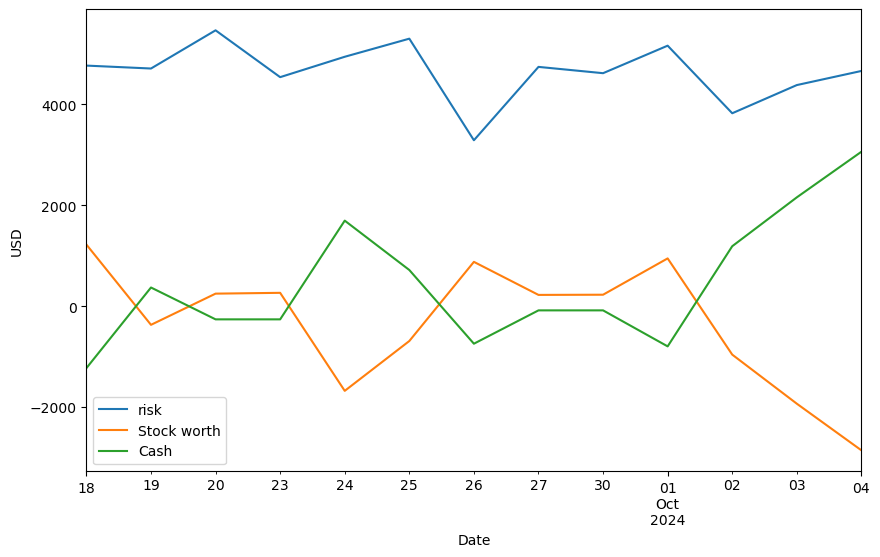

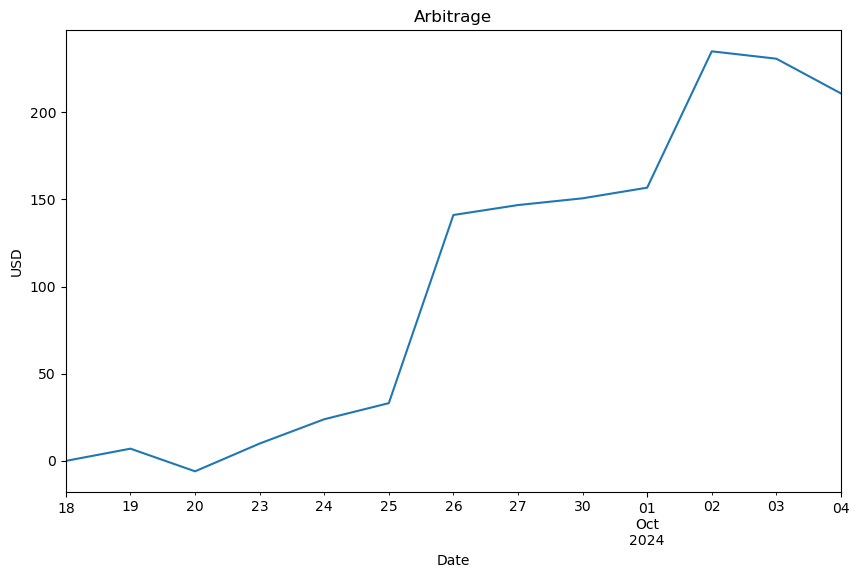

In [11]:
plt.figure(figsize=(10, 6))
Portfolio['risking'].plot(ylabel='USD',label='risk')
Portfolio['stock worth'].plot(label="Stock worth")
Portfolio['cash'].plot(label="Cash")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
Portfolio['Arbitrage'].plot(ylabel='USD',title='Arbitrage')
plt.show()

In [12]:
Initial_value = Portfolio['stock worth'].iloc[0]
Final_value = Portfolio['stock worth'].iloc[-1]
Final_Arbitrage = Portfolio['Arbitrage'].iloc[-1]
Final_risk = Portfolio['risking'].iloc[-1]
max_risk = min(Portfolio['Arbitrage'])
print(f'Final Arbitrage is {Final_Arbitrage:.2f} USD')
print(f"Initial cost is {Initial_value:.2f} USD, final stock values is {Final_value:.2f} USD")
print(f"Risking cost is {Final_risk:.2f}, which makes the profit ratio {Final_Arbitrage/Final_risk*100:.2f} %")
print(f"Mean return is {(Portfolio['Arbitrage']/Portfolio['risking']).mean()*100:.2f} % compared to portfolio worth")

Final Arbitrage is 210.78 USD
Initial cost is 1223.82 USD, final stock values is -2852.26 USD
Risking cost is 4663.12, which makes the profit ratio 4.52 %
Mean return is 2.38 % compared to portfolio worth


Create a system where:
store:{z entrie/exit, Position_book} by day as a SQL database.

In [14]:
Portfolio

,APA,COP,DVN,EOG,FANG,MPC,MRO,MTDR,PSX,XOM,risking,stock worth,cash,Arbitrage
Date,,,,,,,,,,,,,,
2024-09-18,-25.100000,-322.559990,200.900002,-245.220001,1256.569962,1152.129974,-163.020000,-104.000000,387.000000,-912.880005,4769.379934,1223.819941,-1223.819941,0.000000
2024-09-19,102.639999,-552.500000,287.910007,-1013.359985,729.599976,999.300018,-27.889999,53.180000,-132.000000,-813.120026,4711.500011,-366.240009,373.240030,7.000021
2024-09-20,50.500000,-889.280029,244.740005,-750.300018,1254.890030,1154.160034,-111.959999,155.669998,-394.800018,-461.839996,5468.140129,251.780006,-257.769966,-5.989960
2024-09-23,50.419998,-770.699989,163.160004,-879.969994,182.240005,1462.500000,-139.650002,156.600002,389.130020,-345.990005,4540.360020,267.740040,-257.799973,9.940067
2024-09-24,181.650005,-556.699982,292.949989,-1035.199951,-1128.000000,997.140015,56.419998,106.879997,0.000000,-589.199982,4944.139919,-1674.059910,1697.940025,23.880116
2024-09-25,50.540001,-108.500000,203.649998,-1019.760010,-1112.579956,1458.450027,-55.000000,206.320007,389.039978,-698.939987,5302.779964,-686.779942,719.890034,33.110092
2024-09-26,-96.160004,412.000000,0.000000,-608.899994,352.079987,1124.970047,-130.550003,196.600006,-257.739990,-111.139999,3290.140030,881.160049,-740.129906,141.030144
2024-09-27,-23.469999,718.409981,38.290001,-242.399994,1534.950027,-164.000000,-78.000000,193.520004,-1181.880066,-568.800011,4743.720083,226.619944,-79.889849,146.730095
2024-09-30,-48.759998,417.600006,116.730000,-122.279999,1530.990005,163.250000,-52.680000,196.039993,-1046.880005,-923.679993,4618.889999,230.330009,-79.729847,150.600163


In [15]:
Position_book

Ticker,APA,COP,DVN,EOG,FANG,MPC,MRO,MTDR,PSX,XOM
Date,,,,,,,,,,
2024-09-18,-1.0,-3.0,5.0,-2.0,7.0,7.0,-6.0,-2.0,3.0,-8.0
2024-09-19,4.0,-5.0,7.0,-8.0,4.0,6.0,-1.0,1.0,-1.0,-7.0
2024-09-20,2.0,-8.0,6.0,-6.0,7.0,7.0,-4.0,3.0,-3.0,-4.0
2024-09-23,2.0,-7.0,4.0,-7.0,1.0,9.0,-5.0,3.0,3.0,-3.0
2024-09-24,7.0,-5.0,7.0,-8.0,-6.0,6.0,2.0,2.0,0.0,-5.0
2024-09-25,2.0,-1.0,5.0,-8.0,-6.0,9.0,-2.0,4.0,3.0,-6.0
2024-09-26,-4.0,4.0,0.0,-5.0,2.0,7.0,-5.0,4.0,-2.0,-1.0
2024-09-27,-1.0,7.0,1.0,-2.0,9.0,-1.0,-3.0,4.0,-9.0,-5.0
2024-09-30,-2.0,4.0,3.0,-1.0,9.0,1.0,-2.0,4.0,-8.0,-8.0
